## <center>CITS5508 Lab sheet 3: Decision Tree Classification</center>

**Name: Samuel Heath**<br>
**Student number: 21725083**<br>

Looks at two different datasets and performs Decision Tree Classification on each set.

## Project 1 - UCI ecoli Dataset
### Summary:
- Load and clean data.
- Remove Classes that dont have enough instances.
- Remove unneeded features and scale the dataset.
- Compare DT Classifier and SVM Classifier results based on trained data sets.

##### Load Data from `./ecoli.data` and initially visualise the data to see if any classes cant be used.

In [1]:
import pandas as pd

# Set the random seed to ensusre consistent results
random_seed = 12

# Lables we want to add to the data
labels = ["sequence", "mcg", "gvh", "lip", "chg", "aac", "alm1", "alm2", "label"]
ecoli_data = pd.read_csv('./ecoli.data', delim_whitespace=True, names=labels)

ecoli_data = ecoli_data.drop("sequence", axis=1)

ecoli_data.head(10)

,mcg,gvh,lip,chg,aac,alm1,alm2,label
0,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp
5,0.67,0.39,0.48,0.5,0.36,0.38,0.46,cp
6,0.29,0.28,0.48,0.5,0.44,0.23,0.34,cp
7,0.21,0.34,0.48,0.5,0.51,0.28,0.39,cp
8,0.20,0.44,0.48,0.5,0.46,0.51,0.57,cp
9,0.42,0.40,0.48,0.5,0.56,0.18,0.30,cp


## Check the class distribution and remove those with < 10

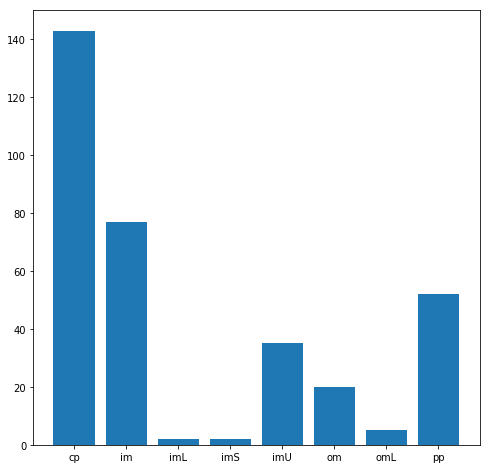

In [3]:
import matplotlib.pyplot as plt

ecoli_data_copy = ecoli_data.copy()

plt.figure(figsize=(8, 8))
plt.bar(x=ecoli_data_copy.sort_values('label')['label'].unique(), height=ecoli_data_copy.groupby('label').size())
plt.show()

From this we see that imL, imS, and omL cannot be used for classificiation due to their low number of training instances, so lets remove these classes from the dataset.

In [4]:
ecoli_data = ecoli_data.drop(ecoli_data[ecoli_data.label.isin(["imL", "imS", "omL"])].index)
ecoli_data.reset_index()

ecoli_data.head()

,mcg,gvh,lip,chg,aac,alm1,alm2,label
0,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp


## Split the dataset into training and testing datasets
Before we learn against this dataset we need to separate out our set into a training and testing set allowing us to validated the accuracy of our model. Peform the split using StratifiedShuffleSplit, resulting in a test size of 20% and training size of 80%.

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

sss = StratifiedShuffleSplit(random_state=random_seed, test_size=0.2, train_size=0.8)

le = LabelEncoder()
ecoli_data.label = le.fit_transform(ecoli_data.label)

for train_index, test_index in sss.split(ecoli_data, ecoli_data.label):
    X_train, X_test = ecoli_data.iloc[train_index], ecoli_data.iloc[test_index]    

# Get the labels of the dataset
y_train, y_test = X_train.label, X_test.label

# Drop Labels from X
X_train = X_train.drop("label", axis=1)
X_test = X_test.drop("label", axis=1)

Create scaled versions of the dataset so the SVM can later be run on both the original and the scaled datasets

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Fit the data to a Model
Make two different models of the data using Support Vector Machines and Decision Trees

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Create a Decision Tree
dt = DecisionTreeClassifier(random_state=random_seed).fit(X_train_scaled, y_train)
dt_test_predict = dt.predict(X_test_scaled)

# Create a Support Vector Classifier
svm = SVC(gamma="auto", random_state=random_seed).fit(X_train_scaled, y_train)
svm_test_predict = svm.predict(X_test_scaled)

### Accuracy of Fitted Models
Compare the accuracy of the fitted models using their cross validated prediction accuracy, f1 score, their confusion matrices.

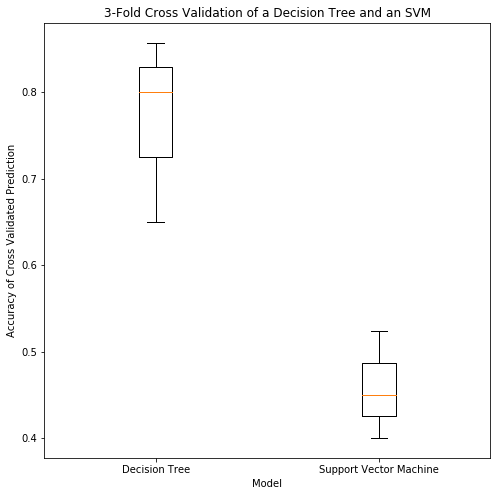

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, confusion_matrix

dt_y_predict = cross_val_score(dt, X_test, y_test, cv=3)
svm_y_predict = cross_val_score(svm, X_test, y_test, cv=3)

plt.figure(figsize=(8,8))
plt.boxplot([dt_y_predict, svm_y_predict], labels=["Decision Tree", "Support Vector Machine"])
plt.title("3-Fold Cross Validation of a Decision Tree and an SVM")
plt.ylabel("Accuracy of Cross Validated Prediction")
plt.xlabel("Model")
plt.show()

## Comments on the Different Models Accuracy

In [9]:
f1_score(y_test, dt_test_predict, average="micro"), f1_score(y_test, svm_test_predict, average="micro")

(0.8333333333333334, 0.7878787878787878)

In [10]:
confusion_matrix(y_test, dt_test_predict)
confusion_matrix(y_test, svm_test_predict)

array([[29,  0,  0,  0,  0],
       [ 3, 13,  0,  0,  0],
       [ 1,  6,  0,  0,  0],
       [ 1,  0,  0,  0,  3],
       [ 0,  0,  0,  0, 10]], dtype=int64)

Comment on confusion matrices differences

### Support Vector Machine Unnormalized
Fit the unscaled data to the Support Vector Machine and compare the results between the two models

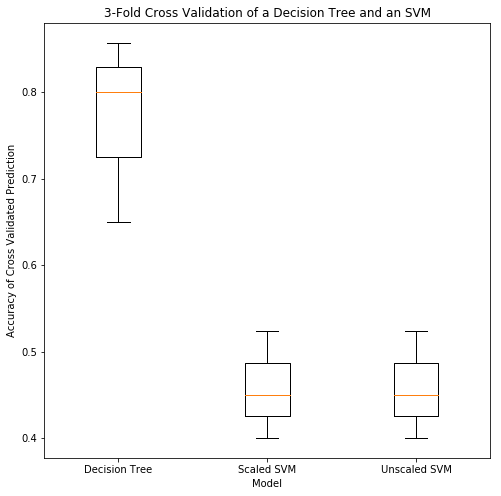

In [11]:
svm_raw = SVC(gamma="auto", random_state=random_seed).fit(X_train, y_train)
svm_raw_y_test_predict = svm_raw.predict(X_test)

svm_raw_y_predict = cross_val_score(svm, X_test, y_test, cv=3)

plt.figure(figsize=(8,8))
plt.boxplot([dt_y_predict, svm_y_predict, svm_raw_y_predict], labels=["Decision Tree", "Scaled SVM", "Unscaled SVM"])
plt.title("3-Fold Cross Validation of a Decision Tree and an SVM")
plt.ylabel("Accuracy of Cross Validated Prediction")
plt.xlabel("Model")
plt.show()

In [12]:
f1_score(y_test, svm_raw_y_test_predict, average="micro")

0.7878787878787878

As expected Support Vector Machines are highly variable based on the feature scaling present. This is shown through the significantly lower f1 score of `45%` of the SVM trained on the unscaled data compared with the `79%` score of the SVM trained on the scaled data.

## Project 2 - BOM Dataset
### Summary:
- Load datasets and create a DT and SVM regressor capable of predicting the maximum temperature based on the solar exposure and a month and date.
- Report the MSE of the two regressors

##### Load Data from `./SolarExposure_2018_Data.csv` and `./Temperature_2018_Data.csv`

In [13]:
solar_exposure = pd.read_csv("./SolarExposure_2018_Data.csv")
solar_exposure.head()

,Product code,Bureau of Meteorology station number,Year,Month,Day,Daily global solar exposure (MJ/m*m)
0,IDCJAC0016,9225,2018,1,1,31.8
1,IDCJAC0016,9225,2018,1,2,31.8
2,IDCJAC0016,9225,2018,1,3,31.7
3,IDCJAC0016,9225,2018,1,4,31.6
4,IDCJAC0016,9225,2018,1,5,24.8


In [14]:
per_temp = pd.read_csv("./Temperature_2018_Data.csv")
per_temp.head()

,Product code,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality
0,IDCJAC0010,9225,2018,1,1,34.0,1,Y
1,IDCJAC0010,9225,2018,1,2,37.7,1,Y
2,IDCJAC0010,9225,2018,1,3,29.8,1,Y
3,IDCJAC0010,9225,2018,1,4,30.9,1,Y
4,IDCJAC0010,9225,2018,1,5,26.1,1,Y
